# NSQIP Personalized Risk Prediction

This notebook shows how we created the personalized risk predictions for the paper: "*Deep Learning in Surgery - Assessing The Utility of Deep Neural Networks in Predicting Postoperative Surgical Complications: A Retrospective Study*"<br><br>
For privacy- and security reasons, we have chosen not to publish the identification numbers of the cases in our test set. Performance metrics will therefore vary slightly from the originally published results <br><br>
The NSQIP database can be requested through the American College of Surgeons website at<br>
https://facs.org <br><br>
Before running this notebook, the NSQIP data should be cleaned. An example notebook can be found at<br> https://github.com/alexbonde/NSQIP/blob/main/NSQIP_data_cleaning.ipynb

### Notebook setup

Import pre-installed packages 

In [1]:
import pandas as pd
from pathlib import Path
from fastai.tabular.all import *

Package versions: 
* *Python v. 3.7.7*<br>
* *Pandas v. 1.1.4*<br>
* *PyTorch v. 1.6.0*<br>
* *Fastai v. 2.0.11*

Set seed for reproducable results

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

Create paths to NSQIP data folder

In [3]:
data_folder = Path(r'E:\Data\NSQIP')

Create subpaths to the folders: datasets and pickles

### Load and preprocess data

In [4]:
nsqip = pd.read_feather(data_folder/'nsqip')

Define categorical input variables

In [5]:
cat_names = ['CPT', 'SEX', 'FNSTATUS2', 'EMERGNCY', 'ASACLAS', 'STEROID', 'ASCITES', 'PRSEPIS', 
             'VENTILAT', 'DISCANCR', 'DIABETES', 'HYPERMED', 'HXCHF', 'DYSPNEA', 'SMOKE', 'HXCOPD', 
             'DIALYSIS', 'RENAFAIL', 'OperYR', 
             'RACE_NEW', 'ETHNICITY_HISPANIC','ANESTHES', 'SURGSPEC', 'WNDCLAS',  'WNDINF',
             'ELECTSURG', 'BLEEDDIS', 'WTLOSS', 'TRANSFUS', 'INOUT', 'TRANST',
             'SSSIPATOS', 'DSSIPATOS', 'OSSIPATOS', 'PNAPATOS', 'VENTPATOS', 'UTIPATOS', 'SEPSISPATOS', 'SEPSHOCKPATOS'
            ]

Define continuous input variables

In [6]:
cont_names = ['HEIGHT', 'WEIGHT', 'Age_cont', 'OPTIME', 'HtoODay', 'WORKRVU', 'PRSODM', 'PRBUN', 'PRCREAT', 
             'PRALBUM', 'PRBILI', 'PRSGOT', 'PRALKPH', 'PRWBC', 'PRHCT', 
             'PRPLATE', 'PRPTT', 'PRINR', 'PRPT']

Define output variables

In [7]:
y_names=['SSSI', 'DSSI', 'OSSI', 'WOUND', 'PNEUMONIA', 'UNPINT', 'PE', 'VENT48', 'PRI', 'ARF', 'UTI', 'STROKE', 'CAR', 'MI', 'DVT', 'SEPSIS', 'SEPSHOCK', 'BLEED', 'DECEASED']

Split data randomly into a training dataset (80%) and a validation dataset (20%)

In [8]:
splits = RandomSplitter(seed=seed)(range_of(nsqip))

Define preprocessing steps:
* *FillMissing = Replace missing values with the median of the group while simultaneously creating a new binary column indicating whether a variable was missing or not*<br>
* *Categorify = Turn categorical variables into categories*<br
* *Normalize = Normalize continous data by subtraction of the mean and division by the standard deviation*

In [9]:
procs = [FillMissing, Categorify, Normalize]

### Create dataloaders

In [10]:
pd.options.mode.chained_assignment=None

In [11]:
%time to = TabularPandas(nsqip, procs, cat_names, cont_names, y_names=y_names, y_block=MultiCategoryBlock(encoded=True, vocab=y_names), splits=splits, inplace=True, reduce_memory=True)

Wall time: 2min 32s


In [12]:
dls = to.dataloaders(1024, num_workers=0)

### Create a Neural Network

We chose the following hyperparameters: 
* *Two hidden layers with 1000 and 500 nodes respectively (layers=[1000,500])*<br>
* *A dropout on the first hidden layer of 0.1% and a dropout on the second layer of 1% (ps=[0.001,0.01])*<br>
* *A dropout on the embedding layers of 4% (embed_p=0.04)*<br>

The number of outpus are 19 (one for each of the dependent variables, n_out = 19)<br>
For performance metrics, we were interested in the average ROC AUC (RocAucMulti()), as well as the ROC AUC for each of the dependent variables (RocAucMulti(average=None))


In [13]:
learn = tabular_learner(dls, layers=[1000,500], 
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), 
                        n_out=19,
                        metrics=[RocAucMulti(),RocAucMulti(average=None)])

### Train- and save the model

We chose to train each model for 5 epochs, with a learning rate of 3e-3 and a weight decay (wd) of 0.2

In [14]:
learn.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.034319,0.034211,0.865776,[0.77622797 0.80957615 0.8498412 0.82801794 0.87396069 0.90127623 0.77457476 0.9459158 0.87686314 0.9378834 0.76993847 0.86856478 0.90382425 0.87956706 0.81067961 0.8416476 0.91642148 0.93638685 0.94858107],05:07
1,0.033435,0.033872,0.870946,[0.78640198 0.81406295 0.85567372 0.83598223 0.87715546 0.90761736 0.7781511 0.94897264 0.88345035 0.94179789 0.77765174 0.88070847 0.91177264 0.88312866 0.81330884 0.84194002 0.92067258 0.93852724 0.95099698],05:06
2,0.033778,0.033542,0.875477,[0.79326029 0.82412439 0.86031536 0.83979068 0.88059268 0.91138015 0.79301422 0.95020194 0.88725835 0.94334524 0.7802372 0.8831351 0.91390009 0.89088747 0.81860401 0.84917751 0.921813 0.93996872 0.95305355],05:06
3,0.033395,0.033166,0.879894,[0.79947459 0.83101449 0.86507253 0.84767205 0.88410925 0.91285661 0.80202219 0.95211833 0.89319132 0.94705377 0.78797783 0.88729251 0.91547677 0.89340134 0.82516185 0.85222783 0.92587577 0.94141608 0.95458021],05:06
4,0.032643,0.032931,0.882399,[0.80335514 0.8350774 0.86799379 0.85169989 0.88617228 0.91460146 0.80596226 0.95325327 0.89643463 0.94842067 0.79103146 0.88955636 0.9179374 0.89545294 0.82837888 0.85435781 0.92737945 0.94285278 0.9556657 ],05:07


Create a seperate dataframe with only the validation data

In [15]:
trn, vld = RandomSplitter(seed=seed)(range_of(nsqip))

In [16]:
valid = nsqip.iloc[vld, :]

### Calculate Shap Values

In [17]:
import shap

The following code integrates fastai and SHapley Additive exPlanations (SHAP). 
* *Published by Z. Mueller (https://github.com/muellerzr)*

In [18]:
def _prepare_data(learn:Learner, test_data=None, n_samples:int=128):
    "Prepares train and test data for `SHAP`, pass in a learner with optional data"
    no_user_provided_test_data = test_data is None
    if isinstance(test_data, pd.DataFrame):
        dl = learn.dls.test_dl(test_data)
    elif isinstance(test_data, TabDataLoader):
        dl = test_data
    elif test_data is None:
        try:
            dl = learn.dls[1]
        except IndexError:
            print('No validation dataloader, using `train`')
            dl = learn.dls[0]
    else:
        raise ValueError('Input is not supported. Please use either a `DataFrame` or `TabularDataLoader`')
    test_data = pd.merge(dl.cats, dl.conts, left_index=True, right_index=True)
    return test_data.sample(n=n_samples) if ((len(test_data) > n_samples) and no_user_provided_test_data) else test_data

def _predict(learn:TabularLearner, data:np.array):
    "Predict function for some data on a fastai model"
    device = 'cpu'
    model = learn.model.to(device)
    dl = learn.dls[0]
    nb_cat_cols = len(dl.dataset.cat_names)
    nb_cont_cols = len(dl.dataset.cont_names)
    x_cat = torch.from_numpy(data[:, :nb_cat_cols]).to(device, torch.int64)
    x_cont = torch.from_numpy(data[:, -nb_cont_cols:]).to(device, torch.float32)
    with torch.no_grad():
        pred_probs = learn.model(x_cat, x_cont).cpu().numpy()
    return pred_probs

class ShapInterpretation():
    "Base interpereter to use the `SHAP` interpretation library"
    def __init__(self, learn:TabularLearner, test_data=None, link='identity', l1_reg='auto', n_samples=128, **kwargs):
        "Initialize `ShapInterpretation` with a Learner, test_data, link, `n_samples`, `l1_reg`, and optional **kwargs"
        self.model = learn.model
        self.dls = learn.dls
        self.class_names = learn.dls.vocab if hasattr(learn.dls, 'vocab') else None # only defined for classification problems
        self.train_data = pd.merge(learn.dls.cats, learn.dls.conts, left_index=True, right_index=True)
        self.test_data = _prepare_data(learn, test_data, n_samples)
        pred_func = partial(_predict, learn)
        self.explainer = shap.SamplingExplainer(pred_func, self.train_data, **kwargs)
        self.shap_vals = self.explainer.shap_values(self.test_data, l1_reg=l1_reg)
        self.is_multi_output = isinstance(self.shap_vals, list)

    def decision_plot(self, class_id=0, row_idx=-1, **kwargs):
        "Visualize model decision using cumulative `SHAP` values."
        shap_vals, exp_val = _get_values(self, class_id)
        n_rows = shap_vals.shape[0]
        if row_idx == -1:
            print(f'Displaying rows 0-9 of {n_rows} (use `row_idx` to specify another row)')
            return shap.decision_plot(exp_val, shap_vals[:10], self.test_data.iloc[:10], **kwargs)
        print(f'Displaying row {row_idx} of {n_rows} (use `row_idx` to specify another row)')
        return shap.decision_plot(exp_val, shap_vals[row_idx], self.test_data.iloc[row_idx], **kwargs)

    def dependence_plot(self, variable_name:str="", class_id=0, **kwargs):
        "Plots value of variable on the x-axis and the SHAP value of the same variable on the y-axis"
        if variable_name is "":
            raise ValueError('No variable passed in for `variable_name`')
        shap_vals, _ = _get_values(self, class_id)
        return shap.dependence_plot(variable_name, shap_vals, self.test_data, **kwargs)

    def force_plot(self, class_id=0, matplotlib=False, **kwargs):
        "Visualize the `SHAP` values with additive force layout"
        shap_vals, exp_val = _get_values(self, class_id)
        if not matplotlib: shap.initjs()
        return shap.force_plot(exp_val, shap_vals, self.test_data, matplotlib=matplotlib, **kwargs)

    def summary_plot(self, **kwargs):
        "Displays `SHAP` values which can be interperated for feature importance"
        return shap.summary_plot(self.shap_vals, self.test_data, class_names=self.class_names, **kwargs)

    def waterfall_plot(self, row_idx=None, class_id=0, **kwargs):
        "Plots explaination of single prediction as waterfall plot"
        shap_vals, exp_val = _get_values(self, class_id)
        n_rows = shap_vals.shape[0]
        row_idx = random.randint(0, n_rows-1) if row_idx is None else row_idx
        print(f'Displaying row {row_idx} of {n_rows} (use `row_idx` to specify another row)')
        feat_names = self.test_data.columns
        return shap.waterfall_plot(exp_val, shap_vals[row_idx,:], feature_names=feat_names, **kwargs)

def _get_class_info(interp:ShapInterpretation, class_id):
    "Returns class name associated with index, or vice-versa"
    if isinstance(class_id, int): class_idx, class_name = class_id, interp.class_names[class_id]
    else: class_idx, class_name = interp.class_names.o2i[class_id], class_id
    return (class_name, class_idx)

def _get_values(interp:ShapInterpretation, class_id=0):
    "Returns `shap_value` and `expected_value`"
    shap_vals = interp.shap_vals
    exp_vals = interp.explainer.expected_value
    if interp.is_multi_output:
        (class_name, class_idx) = _get_class_info(interp, class_id)
        print(f"Classification model detected, displaying score for the class {class_name}.")
        print("(use `class_id` to specify another class)")
        return (shap_vals[class_idx], exp_vals[class_idx])
    else:
        exp_vals = exp_vals[0]
        return (shap_vals, exp_vals)

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?


For this example, we calculate shap values for 1,000 randomly selected patients from the validation dataset

In [19]:
NSQIP_shap_sample = ShapInterpretation(learn, valid.sample(1000))

We can now save the shap results

In [20]:
import pickle

In [21]:
pickle.dump(NSQIP_shap_sample, open( "NSQIP_shap_sample_sample.p", "wb" ) )

We can change the names of our input variables to increase the readability of the final plots

At present, the input variables are the names of the columns in the shap data:

In [22]:
NSQIP_shap_sample.test_data.columns

Index(['CPT', 'SEX', 'FNSTATUS2', 'EMERGNCY', 'ASACLAS', 'STEROID', 'ASCITES',
       'PRSEPIS', 'VENTILAT', 'DISCANCR', 'DIABETES', 'HYPERMED', 'HXCHF',
       'DYSPNEA', 'SMOKE', 'HXCOPD', 'DIALYSIS', 'RENAFAIL', 'OperYR',
       'RACE_NEW', 'ETHNICITY_HISPANIC', 'ANESTHES', 'SURGSPEC', 'WNDCLAS',
       'WNDINF', 'ELECTSURG', 'BLEEDDIS', 'WTLOSS', 'TRANSFUS', 'INOUT',
       'TRANST', 'SSSIPATOS', 'DSSIPATOS', 'OSSIPATOS', 'PNAPATOS',
       'VENTPATOS', 'UTIPATOS', 'SEPSISPATOS', 'SEPSHOCKPATOS', 'HEIGHT_na',
       'WEIGHT_na', 'Age_cont_na', 'OPTIME_na', 'HtoODay_na', 'PRSODM_na',
       'PRBUN_na', 'PRCREAT_na', 'PRALBUM_na', 'PRBILI_na', 'PRSGOT_na',
       'PRALKPH_na', 'PRWBC_na', 'PRHCT_na', 'PRPLATE_na', 'PRPTT_na',
       'PRINR_na', 'PRPT_na', 'HEIGHT', 'WEIGHT', 'Age_cont', 'OPTIME',
       'HtoODay', 'WORKRVU', 'PRSODM', 'PRBUN', 'PRCREAT', 'PRALBUM', 'PRBILI',
       'PRSGOT', 'PRALKPH', 'PRWBC', 'PRHCT', 'PRPLATE', 'PRPTT', 'PRINR',
       'PRPT'],
      dtype='object

These can be changed to: 

In [25]:
features=['CPT code', 'Gender', 'Functional status', 'Emergency case', 'ASA class', 'Steroid use', 'Ascites','System sepsis', 
          'Ventilator dependent', 'Disseminated cancer', 'Diabetes', 'Hypertension', 'Congestive heart failure', 'Dyspnea', 
          'Current smoker', 'History of COPD', 'Dialysis', 'Acute renal failure', 'Operation year', 
          'Race', 'Hispanic ethnicity', 'Principal anesthesia technique', 'Surgical specialty', 'Wound classification', 
          'Open wound/wound infection', 'Elective surgery', 'Bleeding disorder', 'Pre-operative weight loss', 
          'Pre-operative transfusion', 'In/Out-Patient Status', 'Transfer status', 'Superficial SSI PATOS', 'Deep SSI PATOS', 
          'Organ/Space SSI PATOS', 'Pneumonia PATOS', 'On Ventilator > 48 hours PATOS', 'UTI PATOS', 'Sepsis PATOS', 
          'Septic Shock PATOS', 'Missing height', 'Missing time to operation', 'Missing work RVU',
          'Missing weight', 'Missing age', 'Missing serum sodium*', 'Missing BUN*', 'Missing serum creatinine*', 
          'Missing serum albumin*', 'Missing total bilirubin*', 'Missing SGOT*', 'Missing alkaline phosphatase*', 'Missing WBC*', 
          'Missing hematocrit*', 'Missing platelet count*', 'Missing PTT*', 'Missing INR*', 'Missing PT*',
          'Height', 'Weight', 'Age', 'Operatin time', 'Time to operation', 'Work RVU', 
          'Serum sodium*', 'BUN*', 'Serum creatinine*', 'Serum albumin*', 'Total bilirubin*', 'SGOT*', 
          'Alkaline phosphatase*', 'WBC*', 'Hematocrit*', 'Platelet count*', 'PTT*', 'INR*', 'PT*']

In [26]:
NSQIP_shap_sample.test_data.columns = features

We can do the same for the dependent variables

In [27]:
for i in NSQIP_shap_sample.class_names:
    print(i)

ARF
BLEED
CAR
DECEASED
DSSI
DVT
MI
OSSI
PE
PNEUMONIA
PRI
SEPSHOCK
SEPSIS
SSSI
STROKE
UNPINT
UTI
VENT48
WOUND


In [28]:
class_names=['Acute renal failure', 'Bleeding requiring transfusions', 'Cardiac arrest requiring CPR', 'Mortality', 'Deep SSI',
             'DVT/thrombophlebitis', 'Myocardial infarction', 'Organ space SSI', 'Pulmonary embolism', 'Pneumonia', 
             'Progressive renal insufficiency', 'Septic shock', 'Sepsis', 'Superficial SSI', 'Stroke/CVA', 'Unplanned intubation',
             'Urinary tract infection', 'On ventilator >48 h', 'Wound disruption']

In [29]:
NSQIP_shap_sample.class_names = class_names

We can now plot a shap summmary plot, to display the most important input features for Model 3.

In [30]:
import matplotlib.pyplot as pl

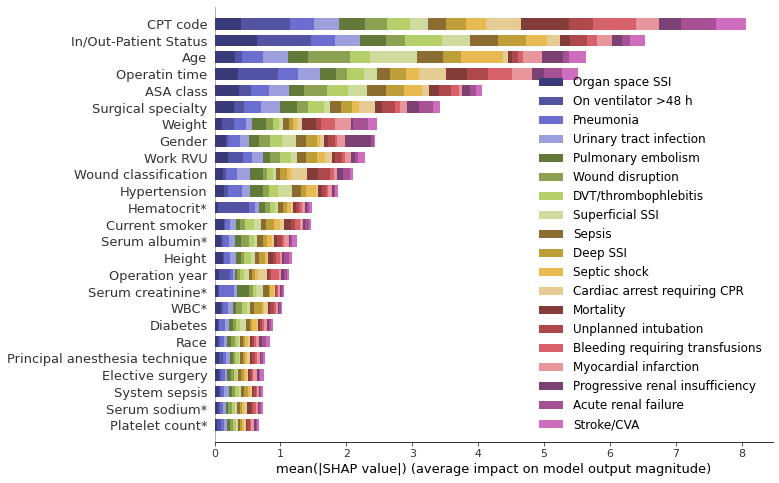

In [31]:
shap.summary_plot(NSQIP_shap_sample.shap_vals, NSQIP_shap_sample.test_data, class_names=NSQIP_shap_sample.class_names, 
                  color=pl.get_cmap('tab20b'), max_display = 25, plot_size = (10, 8), show=False, )
pl.savefig("summary_plot_model3.pdf", bbox_inches='tight')

We can also plot the personalized risk prediction, for the development of a deep surgical site infection, for a randomly selected patient

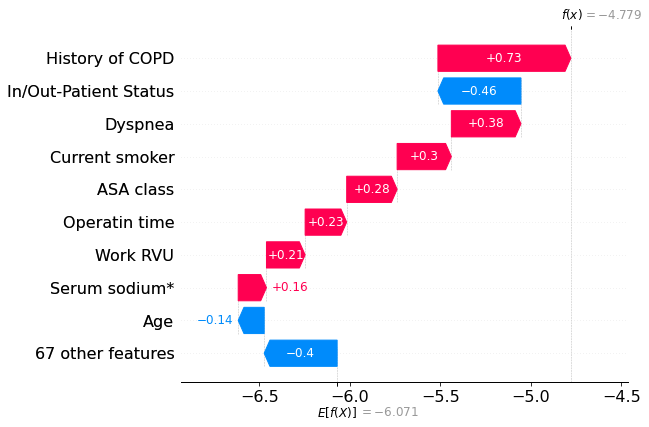

In [32]:
shap.waterfall_plot(NSQIP_shap_sample.explainer.expected_value[4], NSQIP_shap_sample.shap_vals[4][0], 
                    feature_names=NSQIP_shap_sample.test_data.columns, show=False)
pl.savefig("Deep_SSI_waterfall_sample_model3.pdf", bbox_inches='tight')